# Daymet, MODIS, and Leaf Temperature

This notebook shows how to pull Daymet and MODIS LST images off of Planetary Computer, then combine the data into a model of a leaf under extreme drought stress.

### Environment setup

In [1]:
import odc.stac
import odc.geo.geobox
import odc.geo.xr
import planetary_computer as pc
import pystac_client
import pystac
import pyproj
import fsspec
import dask_gateway

import numpy as np
import pandas as pd
import xarray as xr
from scipy.optimize import minimize

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
# Load the PC catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=pc.sign_inplace,
)

# Set up the Dask client
# cluster = dask_gateway.GatewayCluster()
# client = cluster.get_client()
# cluster.scale(4)
# print(cluster.dashboard_link)

### Query for available data

In [3]:
# Eastern Washington
latitude, longitude = 47.387, -119.232
buffer = 0.25
bbox = [longitude - buffer, latitude - buffer, longitude + buffer, latitude + buffer]

# Limit to summer, this is when fire/mortality happens
start = "2020-06-01"
end   = "2020-07-01"

# Fetch the collection of interest and print available items
modis_search = catalog.search(
    collections=["modis-11A1-061"],
    bbox=bbox,
    datetime=[start,end],
    query={"platform": {"eq": "aqua"}}
)

modis_items = modis_search.get_all_items()
print("found {} MODIS images".format(len(modis_items)))

found 62 MODIS images


In [4]:
# Daymet works a little differently. We can only pull the whole dataset, but we make queries
# on it without downloading the whole thing.
daymet_collection = pystac.read_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/daymet-daily-na"
)
asset = daymet_collection.assets['zarr-https']
store = fsspec.get_mapper(asset.href)
ds = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])
ds

<xarray.Dataset>
Dimensions:                  (time: 14965, y: 8075, x: 7814, nv: 2)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(284, 584), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(284, 584), meta=np.ndarray>
  * time                     (time) datetime64[ns] 1980-01-01T12:00:00 ... 20...
  * x                        (x) float32 -4.56e+06 -4.559e+06 ... 3.253e+06
  * y                        (y) float32 4.984e+06 4.983e+06 ... -3.09e+06
Dimensions without coordinates: nv
Data variables:
    dayl                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    srad                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(365, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(365, 284, 584), meta=np.ndarray>
    yearday                  (time) int16 dask.array<chunksize=(365,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

In [5]:
# Subset the Daymet data to only what intersects MODIS

# Set up the projection so we can slice along indexed coordinates (much faster)
# This might be EPSG 9802??
daymet_crs = pyproj.CRS.from_cf(ds.lambert_conformal_conic.attrs)

# Transformer goes from lon/lat to x/y
latlon_daymet_transform = pyproj.Transformer.from_crs("EPSG:4326", daymet_crs, always_xy=True)
# Snap to the nearest km
xmin, ymin = tuple(map(lambda x: round(x, -3), latlon_daymet_transform.transform(bbox[0], bbox[1])))
xmax, ymax = tuple(map(lambda x: round(x, -3), latlon_daymet_transform.transform(bbox[2], bbox[3])))
print(xmin, ymin)
print(xmax, ymax)

-1399000.0 656000.0
-1352000.0 699000.0


In [6]:
%%time

# Slice Daymet to the appropriate data. This is quite fast because
# we are slicing on indexed coordinates.
daymet_subset = ds.sel(
    time=slice(start, end),
    x = slice(xmin, xmax),
    y = slice(ymax, ymin)
)
# Subtract 12 hours from the datetime to align with MODIS (both datasets are daily so
# it's fine).
daymet_subset["date"] = daymet_subset["time"] - pd.Timedelta(hours=12)
daymet_subset = daymet_subset.set_index(time="date")
daymet_subset

CPU times: user 13 ms, sys: 0 ns, total: 13 ms
Wall time: 12.6 ms


<xarray.Dataset>
Dimensions:                  (time: 31, y: 44, x: 47, nv: 2)
Coordinates:
    lat                      (y, x) float32 dask.array<chunksize=(44, 47), meta=np.ndarray>
    lon                      (y, x) float32 dask.array<chunksize=(44, 47), meta=np.ndarray>
  * time                     (time) datetime64[ns] 2020-06-01 ... 2020-07-01
  * x                        (x) float32 -1.398e+06 -1.397e+06 ... -1.352e+06
  * y                        (y) float32 6.99e+05 6.98e+05 ... 6.57e+05 6.56e+05
Dimensions without coordinates: nv
Data variables:
    dayl                     (time, y, x) float32 dask.array<chunksize=(31, 44, 47), meta=np.ndarray>
    lambert_conformal_conic  int16 ...
    prcp                     (time, y, x) float32 dask.array<chunksize=(31, 44, 47), meta=np.ndarray>
    srad                     (time, y, x) float32 dask.array<chunksize=(31, 44, 47), meta=np.ndarray>
    swe                      (time, y, x) float32 dask.array<chunksize=(31, 44, 47), meta=np.ndarray>
    time_bnds                (time, nv) datetime64[ns] dask.array<chunksize=(31, 2), meta=np.ndarray>
    tmax                     (time, y, x) float32 dask.array<chunksize=(31, 44, 47), meta=np.ndarray>
    tmin                     (time, y, x) float32 dask.array<chunksize=(31, 44, 47), meta=np.ndarray>
    vp                       (time, y, x) float32 dask.array<chunksize=(31, 44, 47), meta=np.ndarray>
    yearday                  (time) int16 dask.array<chunksize=(31,), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.6
    Version_data:      Daymet Data Version 4.0
    Version_software:  Daymet Software Version 4.0
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    source:            Daymet Software Version 4.0
    start_year:        1980

### Load MODIS
Must be in the same projection as Daymet. Force resolution/bounds with `odc.geo.geobox`. See [this thread from Pangeo:]( https://discourse.pangeo.io/t/help-coregistering-modis-lst-imagery-and-daymet/3123/4).

In [7]:
# Build the geobox using the shape of one of the data arrays and the CRS we set up from before.
shape = daymet_subset.prcp.shape[1:]
geobox = odc.geo.geobox.GeoBox.from_bbox(
    daymet_subset.rio.bounds(), crs=daymet_crs, shape=shape, anchor=odc.geo.geobox.AnchorEnum.FLOATING
)

modis_data = odc.stac.load(
    modis_items,
    bands=["LST_Day_1km", "QC_Day", "Day_view_time", "Day_view_angl"],
    geobox=geobox,
    chunks={},
    resampling=dict(
        LST_Day_1km="bilinear",
        Day_view_time="bilinear",
        Day_view_angl="bilinear",
        QC_Day="nearest" # this asset is a bitmask
    )
)

modis_data

<xarray.Dataset>
Dimensions:        (y: 44, x: 47, time: 31)
Coordinates:
  * y              (y) float64 6.99e+05 6.98e+05 6.97e+05 ... 6.57e+05 6.56e+05
  * x              (x) float64 -1.398e+06 -1.397e+06 ... -1.353e+06 -1.352e+06
    spatial_ref    int32 0
  * time           (time) datetime64[ns] 2020-06-01 2020-06-02 ... 2020-07-01
Data variables:
    LST_Day_1km    (time, y, x) uint16 dask.array<chunksize=(1, 44, 47), meta=np.ndarray>
    QC_Day         (time, y, x) uint8 dask.array<chunksize=(1, 44, 47), meta=np.ndarray>
    Day_view_time  (time, y, x) uint8 dask.array<chunksize=(1, 44, 47), meta=np.ndarray>
    Day_view_angl  (time, y, x) uint8 dask.array<chunksize=(1, 44, 47), meta=np.ndarray>

Verify that the two datasets are coregistered, then assimilate into one `Dataset`.

In [8]:
assert modis_data.rio.transform() == daymet_subset.rio.transform()

coreg = xr.merge(
    [modis_data, daymet_subset]
).load() # load into memory to make xr.apply_ufunc() happy later
coreg

/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


<xarray.Dataset>
Dimensions:                  (y: 44, x: 47, time: 31, nv: 2)
Coordinates:
  * y                        (y) float64 6.99e+05 6.98e+05 ... 6.57e+05 6.56e+05
  * x                        (x) float64 -1.398e+06 -1.397e+06 ... -1.352e+06
    spatial_ref              int32 0
  * time                     (time) datetime64[ns] 2020-06-01 ... 2020-07-01
    lat                      (y, x) float32 47.54 47.54 47.54 ... 47.24 47.24
    lon                      (y, x) float32 -119.6 -119.6 ... -118.9 -118.8
Dimensions without coordinates: nv
Data variables: (12/14)
    LST_Day_1km              (time, y, x) uint16 15836 15795 15752 ... 15297 0
    QC_Day                   (time, y, x) uint8 0 0 0 0 0 0 ... 65 65 65 65 65 2
    Day_view_time            (time, y, x) uint8 133 133 133 133 ... 135 135 255
    Day_view_angl            (time, y, x) uint8 92 92 92 92 ... 109 109 109 255
    dayl                     (time, y, x) float32 5.589e+04 ... 5.635e+04
    lambert_conformal_conic  int16 -32767
    ...                       ...
    swe                      (time, y, x) float32 0.0 0.0 0.0 ... 0.0 0.0 0.0
    time_bnds                (time, nv) datetime64[ns] 2020-06-01 ... 2020-07-02
    tmax                     (time, y, x) float32 22.79 22.64 ... 23.02 22.89
    tmin                     (time, y, x) float32 6.91 6.82 6.72 ... 10.3 10.09
    vp                       (time, y, x) float32 452.4 443.1 ... 765.7 774.1
    yearday                  (time) int16 153 154 155 156 ... 180 181 182 183

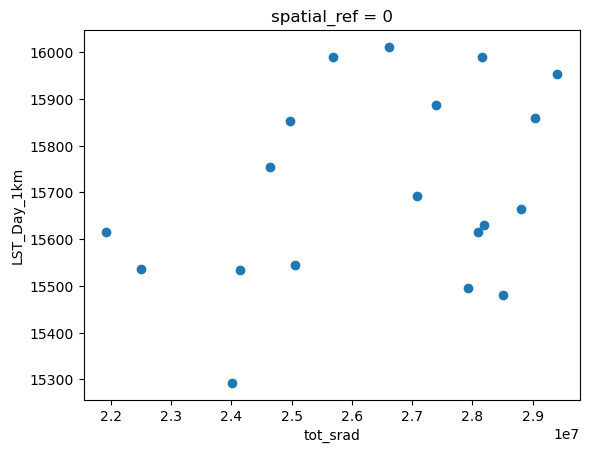

In [9]:
# Sanity check: plot afternoon LST vs. total shortwave radiation received during daylight
coreg["tot_srad"] = coreg["srad"] * coreg["dayl"]
coreg.where(coreg["QC_Day"] == 0).mean(dim=["x", "y"]).plot.scatter(
    x="tot_srad", y="LST_Day_1km"
)

### Leaf energy balance model

Assuming thermal equilibrium, a leaf's temperature can be calculated by balancing incoming and outgoing heat.

$$
R_{net} = H + \lambda E
$$

Here, $R_{net}$ is net radiation flux, $H$ is sensible heat flux, and $\lambda E$ is latent heat flux. Since latent heat flux is hard to measure, we will assume it is zero and accept that our modeled temperature is a "maximum stress" temperature. Note that this is a similar approach to the crop water stress index in [Idso et al. (1981)](https://www.sciencedirect.com/science/article/pii/0002157181900327).

So, we are left with $R_{net}$ and $H$. A parameterization for these values comes from [Okajima et al. (2012)](https://doi.org/10.1007/s11284-011-0905-5), with approximations for boundary layer conductance to heat and diffuse downwelling shortwave radiation.

$$
\begin{align}
R_{net} &= S_{\downarrow} \alpha_S + \epsilon \sigma \left( \left[T_a - \frac{20S_{\downarrow}}{1000}\right]^4 + T_a^4 - 2T_l^4  \right)
\newline
H &= \frac{2|T_l - T_a|^\frac{1}{3} c_p P}{400R_{air}}
\end{align}
$$

This looks a little intimidating, but many of the variables ($\sigma$, $\epsilon$, $R_{air}$, $c_p$) are just constants. The only variables that change are downwelling shortwave radiation ($S_\downarrow$), atmospheric pressure ($P$), air temperature ($T_a$), and our goal, leaf temperature ($T_l$). Downwelling shortwave and air temperature are provided in Daymet, and for now we will just assume 1 bar for atmospheric pressure. We cannot solve directly for $T_l$, so we will instead solve for leaf temperature by iteration.

In [10]:
# Define all the constants
sigma  = 5.670374419e-8 # Stefan-Boltzmann constant (W m-2 K-4)
eps    = 0.95 # Emissivity of leaves (unitless)
alpha  = 0.55 # Absorptivity to shortwave radiation (unitless)
cp     = 29.3 # Heat capacity of air (J mol-1 K-1)
Rair   = 287.058 # Specific gas constant for dry air (J kg-1 K-1)
P_1bar = 100000 # 1 bar (typical air pressure at sea level) in Pa


# Compute the components of the energy balance in case we can see what is driving
# leaf temperature.
def net_radiated_heat_flux(Tl, Ta, P, S):
    return S * alpha + sigma * eps * ( (Ta - (20 * S / 1000)) ** 4 + Ta ** 4 - 2 * Tl ** 4)
    
def net_sensible_heat_flux(Tl, Ta, P, S):
    return 2 * np.abs(Tl - Ta) ** (1/3) * cp * P / (400 * Rair)

def eval_energy_balance(Tl, Ta, P, S):
    # Compute Rnet
    Rnet = net_radiated_heat_flux(Tl, Ta, P, S)
    # Compute H
    H    = net_sensible_heat_flux(Tl, Ta, P, S)
    
    return np.abs(Rnet - H)

@np.vectorize
def _energy_balance_driver(Ta, S):
    init_Tl = 300 # K
    balance_result = minimize(
        eval_energy_balance,
        [init_Tl],
        (Ta, P_1bar, S)
    )
    
    Tl   = balance_result.x
    Rnet = net_radiated_heat_flux(Tl, Ta, P_1bar, S)
    H    = net_sensible_heat_flux(Tl, Ta, P_1bar, S)
    
    return Tl, Rnet, H

# Test it out
# Cool day, full sun
print(_energy_balance_driver(290, 800))

(array([309.41336427]), array([137.16234609]), array([137.16234598]))


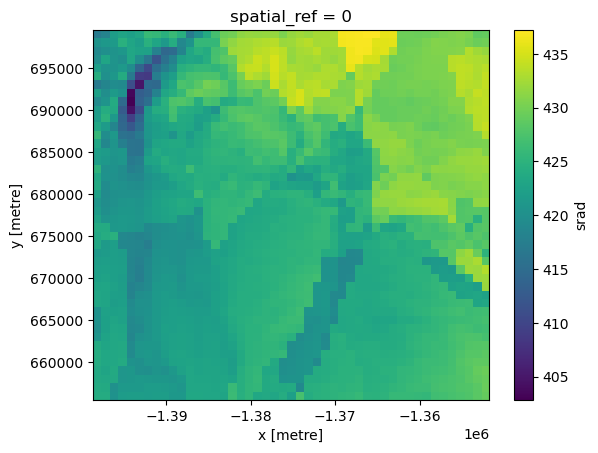

In [11]:
# Now run the optimization on the coregistered dataset. This is very slow, so we will compute the
# "mean energy balance" for the month of June.
coreg_summary = coreg.mean(dim="time")
coreg_summary.srad.plot.imshow()

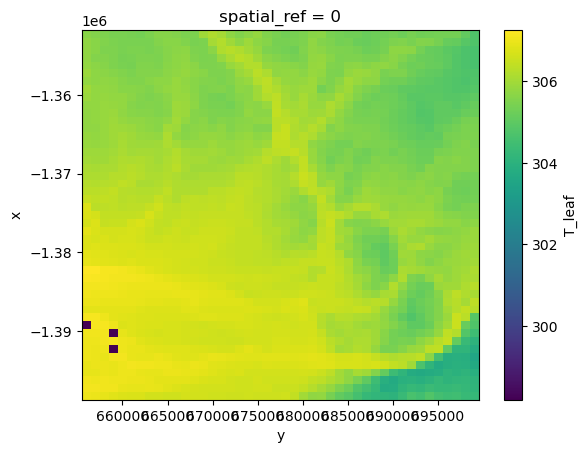

In [12]:
coreg_summary["T_leaf"], coreg_summary["R_net"], coreg_summary["H_net"] = xr.apply_ufunc(
    _energy_balance_driver,
    (coreg_summary["tmax"] + 273.15), # convert to K
    coreg_summary["srad"],
    input_core_dims = [["x", "y"], ["x", "y"]],
    output_core_dims = [["x", "y"], ["x", "y"], ["x", "y"]],
    dask = "allowed"
)

coreg_summary["T_leaf"].plot.imshow()

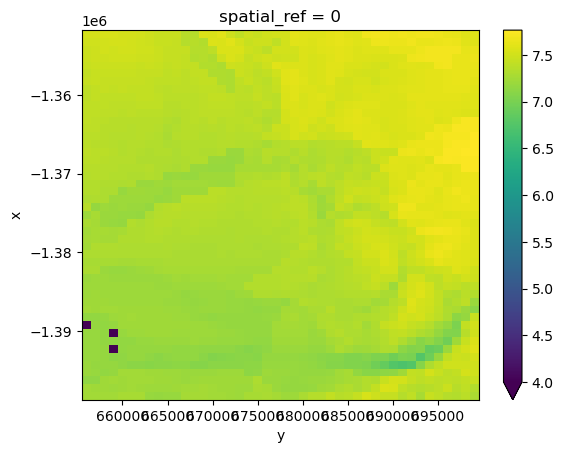

In [13]:
# Difference between leaf temperature and air temperature
(coreg_summary["T_leaf"] - (coreg_summary["tmax"] + 273.15)).plot.imshow(vmin=4)